# Лабораторная работа №1

# Задание

Необходимо познакомиться с фреймворком машинного обучения PyTorch и выполнить три задания:
1. Регрессия по теореме универсальной аппроксимации, ручное дифференцирование
2. Бинарная классификация с помощью автодиффиренцирования PyTorch
3. Обучить полносвязную нейронную сеть классификации 3 классов изображений из набора данных CIFAR100 по варианту из примера и затем повысить точность на тестовой выборке.

Для задания 3 нужно сформировать свою подвыборку CIFAR100 по варианту.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы, итоговую таблицу со результатами для всех вариантов обучения.

# Варианты для Задания 3
Вы должны использовать следующие классы из CIFAR100:
1. Номер группы + 15
2. Номер варианта + 56
3. ИУ5 (Номер варианта + 21); ГУИМЦ (80); Иностранцы (90)

(39, 58, 23)

# Задания для самостоятельной работы
1. Проанализируйте результаты обучения вашей модели. Что говорит о ней точность на обучающей и тестовой выборке? С какими классами модель справляется лучше и почему?
2. Проанализируйте результаты обучения. Возникает ли переобучение вашей модели? Что необходимо сделать, чтобы нивелировать это (не используя регуляризацию)?
3. Измените размер батча, но сохраните общее количество итераций. Проанализируйте результаты обучения с новыми гиперпараметрами. Что изменилось и почему?
4. Уменьшите скорость обучения и увеличьте общее количество итераций, чтобы повысить точность модели.
5. Измените вашу модель - поменяйте количество нейронов и слоев. Проанализируйте результаты обучения новой модели. Найдите лучшие гиперпараметры для этой модели.
6. Укажите, какие действия помогли повысить точность вашей модели и объясните почему.

# Комментарии к самостоятельной работе
- Изменение скорости обучения и размера батча делаем только после нахождения момента переобучения - эпохи где ошибка на тестовой выборке самая маленькая. Иначе улучшением шагов вы можете усилить переобучение (улучшаться при обучении, ухудшаться для теста).

- увеличение размера батча при том же числе итераций должно хоть немного (в среднем) улучшить обучение. Потому что мы делаем такое же количество, но более хороших шагов. Это может не сходится с опытом по разным причинам, но из теории мы ожидаем какое-то улучшение

- Во сколько раз меняете скорость обучения или размер батча - во столько же меняете количество эпох для сохранения итераций. На практике это условие не нужно, потому что при новом обучении меняют сразу много гиперпараметров. Но мы учимся, поэтому исследуем поведение каждого гиперпараметра отдельно: мы не можем сравнить 5 больших шагов и 7 маленьких, можем сравнить 5 больших и 5 маленьких.

- При изменении модели нужно искать гиперпараметры заново - это новая модель. Не нужно расписывать снова все шаги, просто сделайте это сами - найдите переобучение и поищите скорость и размер батча, которые будут лучше.

# Контрольные вопросы для защиты
1. Полносвязная нейронная сеть, объясните структуру, вычисления и назначение слоев и составляющих нейронов.
2. Укажите количество нейронов, связей и весов в полносвязной нейронной сети
3. Опишите задачи регрессии и классификации. Какие функции потерь применяются в этих задачах?
4. Опишите структуру набора данных, назначение его частей
5. Опишите алгоритм стохастического градиентного спуска. Укажите назначение гиперпараметров. В чем отличие пакетного и стохастического спуска?
6. Что такое эпоха, итерация, батч обучения. Как они взаимосвязаны?
7. Что такое обучение с учителем, без учителя, с подкреплением? Приведите примеры методов и задач для каждого вида обучения.

# Описание итоговой таблицы

|  Конфигурация нейросети   |  Гиперпараметры  |  Точность  |  Комментарий
|----------|----------|----------|----------|
|  FC(10), FC(3)   | lr = 0.003, batch_size = 128, epochs = 100  |  test = 70%, train = 98%  |  Базовый вариант
|  FC(10), FC(3)   | lr = 0.001, batch_size = 128, epochs = 300  |  test = 72%, train = 99%  |  Уменьшили скорость обучения в 3 раза, для компенсации увеличили количество эпох в столько же раз

## Импортирование необходимых библиотек

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Часть 1. Задача регрессии по теореме универсальной аппроксимации, ручное дифференцирование

## Генерация выборки и инициализация параметров нейронной сети

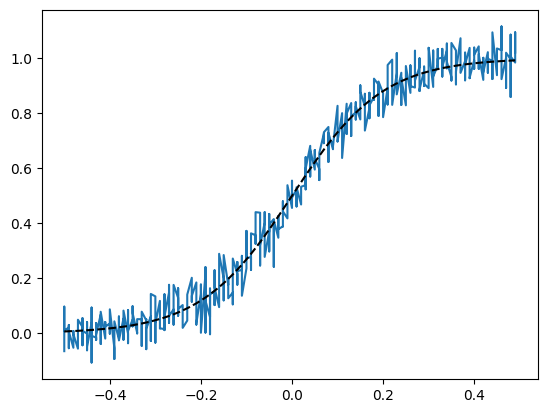

In [2]:
# Генерируем аргументы
X = (np.arange(100)/100 - 0.5).repeat(5)

# Генерируем значения
y = 1/(1+np.exp(-10*X))
# Добавляем ошибку
yn = np.random.normal(scale=0.05, size=y.size)+y

# Строим график
plt.plot(X, yn)
plt.plot(X, y, linestyle='--', c='k')

In [3]:
################################################
# reshape - функция для изменения формы массивов
tensor_X = torch.Tensor(X.reshape(-1, 1))
tensor_y = torch.Tensor(yn.reshape(-1, 1))

# Размер внутреннего слоя (кол-во нейронов)
HIDDEN_SIZE = 64

# У каждого нейрона столько входов, сколько нейронов в предыдущем слое.

# Инициализация весов MLP (Multilayer Perceptron) с одним скрытым слоём
# веса - у каждого нейрона скрытого слоя по одному весу (т.к. входной нейрон - один), 
# кол-во нейронов в скрытом слое - 64, соответственно, весов будет 1 на 64
weights_1 = (torch.rand(1, HIDDEN_SIZE)-.5)/10 
# коэффициенты (или параметры, хз как лучше) смещения для нейронов скрытого слоя, их 64
bias_1 = torch.zeros(HIDDEN_SIZE)

# Аналогично, веса и смещение для выходного слоая
weights_2 = (torch.rand(HIDDEN_SIZE, 1)-.5)/10
# Мы апроксимируем функцию (1 аргумент, 1 выходное значение),
# поэтому в последнем (выходном) слое 1 нейрон
bias_2 = torch.zeros(1)

## Обучение нейронной сети задачи регрессии

0.0025449726


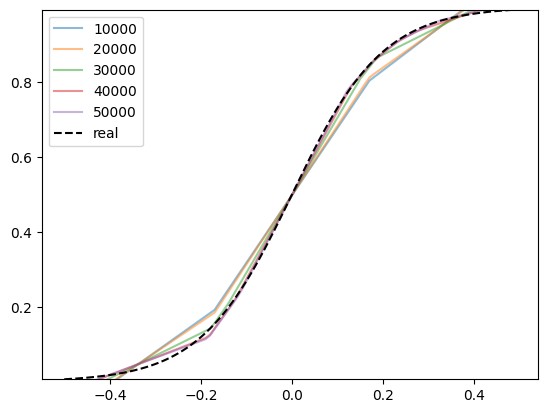

In [4]:
# Определяем функцию нелинейности
# функция relu - от -беск до 0: 0, от 0 до беск: x
relu = lambda x: torch.maximum(x, torch.Tensor([0]))

# Прямой проход
# Умножаем вход на веса weights_1, добавляем bias_1, применяем к этому всему функцию активации, умножаем результат на weights_2.
# Затем суммируем результаты и добавляем bias_2 - это и будет выход НС
forward = lambda x: (weights_2.t() * relu((weights_1 * x) + bias_1)).\
                    sum(axis=-1, keepdims=True) + bias_2
# Функция потерь
loss = lambda y, y_: ((y - y_)**2).sum(axis=-1)

# Обратный проход
# Градиент считаем от функции потерь
# Считаем 4 градиента - для весов и смещений 1 слоя, для весов и смещений 2 слоя
def backward(X, y, y_pred):
    # производная функции потерь по y_pred
    dL = 2*(y_pred - y)
    # значения нейронов скрытого слоя до применения активации
    Ax = (weights_1*X) + bias_1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)

    # 1. Сначала находим производную выходного слоя
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights_2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax<=0] = 0

    # 2. Затем производную скрытого слоя
    # производная функции потерь по weight_1
    dW = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db = dA.sum(axis=0)
    #print(dW.shape, db.shape, dW2.shape, db2.shape)
    return dW, db, dW2, db2

# функция оптимизации
# коэффициент обучения = 0.001
def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    # вычитаем из весов градиент
    W1 -= lr*grads[0]
    W2 -= lr*grads[2]
    b1 -= lr*grads[1]
    b2 -= lr*grads[3]
    return W1, b1, W2, b2

# Само обучение!
for i in range(50000): # 50 тысяч итераций градиентного спуска == 50 тысяч эпох
  output = forward(tensor_X) # прогоняем нейронную сеть вперед (даем значения, получаем результат)
  cur_loss = loss(output, tensor_y) # значение ошибки
  grads = backward(tensor_X, tensor_y, output)  # делаем обратный проход. Передаем, по факту, параметры функции, 
                                                # определяющей (задающей) нашу нейронную сеть
                                                # на выходе получаем градиенты нашего веса
  params = [weights_1, bias_1, weights_2, bias_2]
  weights_1, bias_1, weights_2, bias_2 = optimize(params, grads, 1e-4)  # оптимизируем параметры (двигаем их с помощью градиента)
                                                                        # последний параметр - скорость обучения
  if (i+1)%10000 == 0:
      plt.plot(X, output.numpy(), label=str(i+1), alpha=0.5)

plt.plot(X, y, linestyle='--', c='k', label='real')
plt.legend()
plt.ylim(y.min(), y.max())
# сумма квадратов потерь
print(cur_loss.numpy().mean())

# Часть 2. Бинарная классификация с помощью автодиффиренцирования PyTorch

## Генерация выборки и инициализация параметров нейронной сети

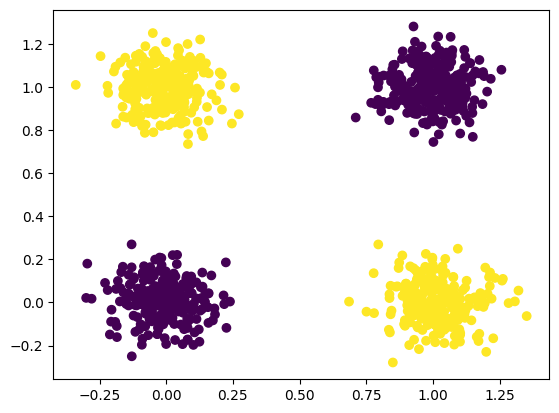

In [5]:
X = np.random.randint(2, size=(1000, 2))

# y используем для идентификации цвета.
# Таким образом, точки (0,0) и (1,1) будут одного цвета (фиолетового)
# точки (0,1) и (1,0) будут другого цвета (желтого)
y = (X[:, 0] + X[:, 1]) % 2 # XOR
# добавляем разброс
X = X + np.random.normal(0, scale=0.1, size=X.shape)
#X, y = make_circles(n_samples=1000, noise=0.025)
#X, y = make_moons(n_samples=1000, noise=0.025)
# scatter - отрисовка точек.
# c - цвет
plt.scatter(X[:, 0], X[:, 1], c=y)

In [6]:
tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 16
# Инициализация весов MLP с одним скрытым слоём
# requires_grad_ - параметр для автоматического поиска градиента
weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)

## Обучение нейронной сети задачи классификации

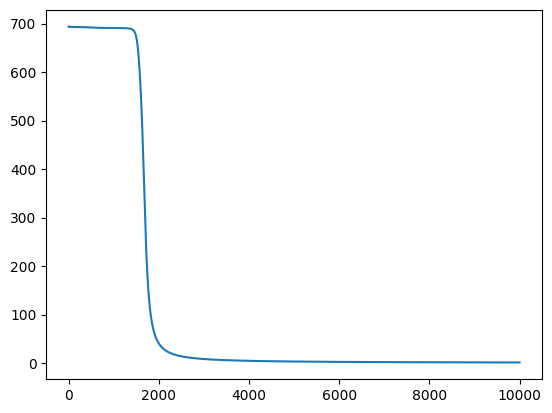

In [7]:
# Определяем функцию нелинейности
def sigmoid(x):
    return 1/(1+torch.exp(-x))

# Прямой проход
def forward(x):
    hidden = torch.mm(x, weights_1) + bias_1
    hidden_nonlin = sigmoid(hidden)
    output = (weights_2.t()*hidden_nonlin).sum(axis=-1,keepdims=True) + bias_2
    return sigmoid(output)

# Logloss - функция потерь
def loss(y_true, y_pred):
    return -1*(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1-y_pred)).sum()

# задаём шаг обучения (learning rate)
lr = 1e-3
# задаём число итераций
iters = 10000
params = [weights_1, bias_1, weights_2, bias_2]
losses = []
for i in range(iters):
    output = forward(tensor_X)
    lossval = loss(tensor_y, output)
    lossval.backward() # тут включается в работу autograd
    for w in params:
        with torch.no_grad():
            w -= w.grad*lr # обновляем веса
        w.grad.zero_() # зануляем градиенты, чтобы не накапливались за итерации
    losses.append(lossval.item())

# выводим историю функции потерь по итерациям
plt.plot(losses)

## Проверка результатов обучения

(-0.5082841172051609, 1.5203160913881117)

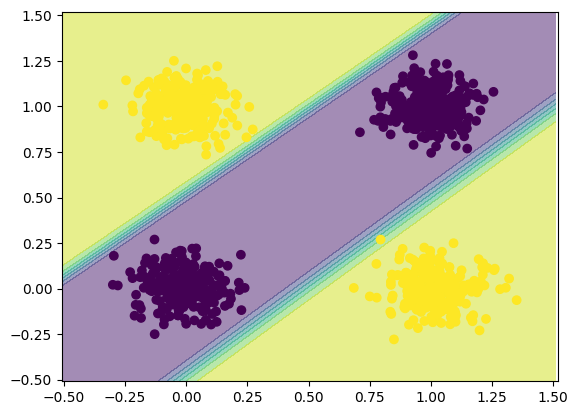

In [8]:
X_diff = X.max() - X.min()
X_left = X.min() - 0.1*X_diff
X_right = X.max() + 0.1*X_diff
grid = np.arange(X_left, X_right, 0.01)
grid_width = grid.size
surface = []
# создаем точки по сетке
for x1 in grid:
    for x2 in grid:
        surface.append((x1, x2))
surface = np.array(surface)
# получаем предсказания для всех точек
with torch.no_grad():
    Z = forward(torch.Tensor(surface)).detach().numpy()
# меняем форму в виде двухмерного массива
Z = Z.reshape(grid_width, grid_width)
xx = surface[:, 0].reshape(grid_width, grid_width)
yy = surface[:, 1].reshape(grid_width, grid_width)
# рисуем разделяющие поверхности классов
plt.contourf(xx, yy, Z, alpha=0.5)
# рисуем обучающую выборку
plt.scatter(X[:, 0], X[:, 1], c=output.detach().numpy()>0.5)
# задаём границы отображения графика
plt.xlim(X_left, X_right)
plt.ylim(X_left, X_right)

# Часть 3. Классификация изображений CIFAR100

## Загрузка и распаковка набора данных CIFAR100

При необходимости, установить wget для Windows: https://phoenixnap.com/kb/wget-command-with-examples

In [ ]:
#!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
#!tar -xvzf cifar-100-python.tar.gz

## Чтение тренировочной и тестовой выборки

In [24]:
with open('cifar/cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar/cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
# 1. Номер группы + 15
# 2. Номер варианта + 56
# 3. ИУ5 (Номер варианта + 21); ГУИМЦ (80); Иностранцы (90)
# (39 — клавиатуры, 58 — внедорожники, 23 — облака)
CLASSES = [39, 58, 23]

# массив
train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES) # фильтруем данные, выбираем только те, которые относятся к нашим классам

train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)

test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

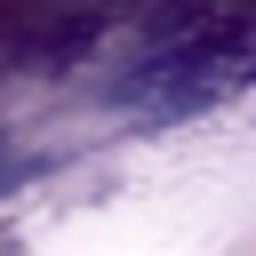

In [21]:
Image.fromarray(train_X[1]).resize((256,256))

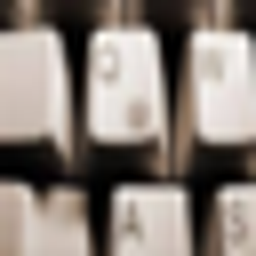

In [13]:
Image.fromarray(train_X[2]).resize((256,256))

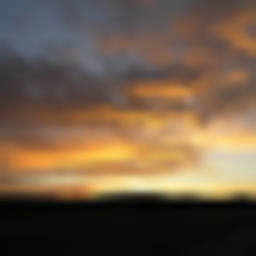

In [14]:
Image.fromarray(train_X[13]).resize((256,256))

## Создание Pytorch DataLoader'a

In [25]:
batch_size = 128
dataloader = {}

# функция zip позволяет пройтись одновременно по нескольким итерируемым объектам (спискам и др.)
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader (из библиотеки torch)

dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x1fecb77d700>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1fecb77e990>}

## Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [26]:
# класс для нормализации данных (на вход поступают цвета от 0 до 255, нормализуем их)
# но нормализуем через специальные коэффициенты (они указаны ниже), которые, видимо, были расчитаны заранее
class Normalize(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        # вытягиваем изображение в линию
        return torch.flatten(x, start_dim=1) # nhwc -> nm

# класс, который используем для создания моделей НС
class Cifar100_MLP(nn.Module):
    # функция, которая выполняется при создании объекта класса
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        # nn.Sequential - конвейер для создания НС
        self.seq = nn.Sequential(
            # полносвязный слой (входной - скрытый)
            nn.Linear(32*32*3, hidden_size),
            # функция активации для нейронов скрытого слоя
            nn.ReLU(),
            # полносвязный слой (скрытый - выходной)
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        # сначала нормализуем изображение
        x = self.norm(input)
        # затем передаем изображение в НС (а внутри модели, видимо, вызывается forward от класса Normalize)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

## Выбор функции потерь и оптимизатора градиентного спуска

In [27]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор — это метод достижения лучших результатов, помощь в ускорении обучения.
# Другими словами, это алгоритм, используемый для незначительного изменения параметров,
# таких как веса и скорость обучения, чтобы модель работала правильно и быстро
optimizer = optim.SGD(model.parameters(), lr=0.005)

## Обучение модели по эпохам

In [28]:
EPOCHS = 250
# train data set
steps_per_epoch_train = len(dataloader['train'])
# test data set (валидация)
steps_per_epoch_test = len(dataloader['test'])

losses_train_x = []
losses_train_y = []
losses_test_x = []
losses_test_y = []

for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()

    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    
    #print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss / steps_per_epoch_train:.3f}')

    # график
    losses_train_x.append(epoch)
    losses_train_y.append(running_loss / steps_per_epoch_train)

    running_loss = 0.0
    model.eval() # модель переводится в evaluation mode (режим оценки)
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, batch in enumerate(dataloader['test'], 0):
            inputs, labels = batch

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    #print(f'[{epoch + 1}, {i + 1:5d}] validation loss: {running_loss / steps_per_epoch_train:.3f}')

    # график
    losses_test_x.append(epoch)
    losses_test_y.append(running_loss / steps_per_epoch_test)

print('Обучение закончено')

Обучение закончено


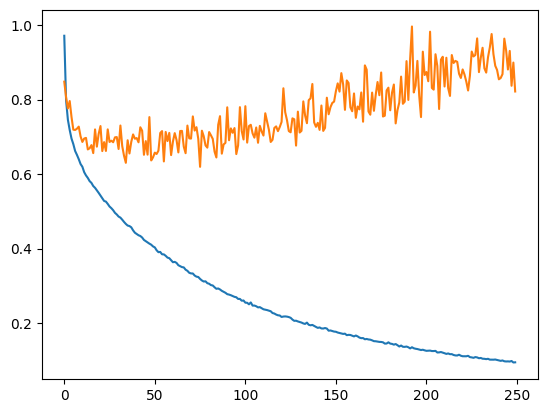

In [29]:
# выводим историю функции потерь по итерациям
plt.plot(losses_train_x, losses_train_y)
plt.plot(losses_test_x, losses_test_y)

min_losses_test_y = max(losses_test_y)
min_losses_test_x = 0
for i in range(0, len(losses_test_y)):
    if losses_test_y[i] < min_losses_test_y:
        min_losses_test_y = losses_test_y[i]
        min_losses_test_x = i

plt.Circle((min_losses_test_x, min_losses_test_y), 10, color='b', fill=False)

In [30]:
print(min_losses_test_x)
print(min_losses_test_y)

75
0.619335780541102


## Проверка качества модели по классам на обучающей и тестовой выборках

In [32]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          39     0.9878    0.9700    0.9788       500
          58     0.9763    0.9880    0.9821       500
          23     0.9881    0.9940    0.9910       500

    accuracy                         0.9840      1500
   macro avg     0.9840    0.9840    0.9840      1500
weighted avg     0.9840    0.9840    0.9840      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          39     0.6583    0.7900    0.7182       100
          58     0.6207    0.5400    0.5775       100
          23     0.7957    0.7400    0.7668       100

    accuracy                         0.6900       300
   macro avg     0.6916    0.6900    0.6875       300
weighted avg     0.6916    0.6900    0.6875       300

--------------------------------------------------


## Визуализация весов

(10, 3072)


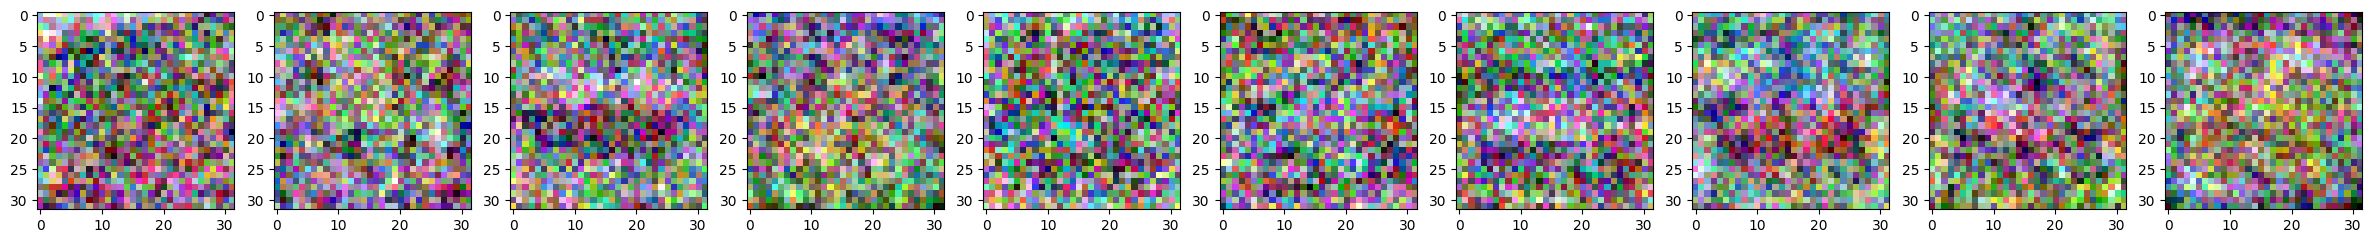

In [25]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1)
    ax[i].imshow(ω)

# Описание методов библиотек

Библиотеки:

* __np__ - библиотека NumPy для работы с многомерными массивами данных
* __pickle__ - библиотека Pickle для сериализации и десериализации структур данных ЯП Python
* __sklearn__ - библиотека, реализующая в основном методы классического машинного обучения и инструменты для работы с ними
* __PIL__ - легковесная библиотека Pillow для работы с изображениями и вывода графических элементов напрямую в Jupyter Notebook
* __matplotlib__ - библиотека для построения графиков, по большей части повторяет API Matlab'a
* __torch__ - библиотека Pytorch для глубокого обучения нейронных сетей

### Методы и функции PyTorch

(Документация: https://pytorch.org/docs/stable/index.html)

__Принятые сокращения__:
* torch.nn - nn
* torch.nn.functional - F
* torch.optim - optim

__Методы__:
* __torch.Tensor__ - cоздает тензор из многомерного массива Numpy и наследует его тип данных. По умолчанию память под тензоры выделяется на CPU. При выставлении флага __requires_grad__ автоматически отслеживает градиенты с помощью движка autograd, который строит динамический вычислительный граф. Включить отслеживания тензора __t__ можно так же при помощи метода __t.requires_grad_(True)__. В таком случае после вызова метода __backward__, в поле __grad__ будут записаны производные. Производные тензора __t__ можно очистить вызовом метода __t.grad.zero_()__. Для того чтобы отсечь ненужные вычисления производных используется метод __detach__, который создаёт копию тензора, при этом флаг __requires_grad__ снимается и отслеживание движком autograd прекращается.

* __torch.numpy__ - создает многомерный NumPy массив данных из тензора

* __torch.item__ - возвращает число, но только если ранг тензора 0. В противном случае выдаёт ошибку и следует использовать torch.numpy

* __torch.uint8__, __torch.int16__, __torch.int64__, __torch.float32__ - приведение массива к новому типу, аналогично NumPy. Для приведения используется метод .to (например `t.to(torch.int64)`). По умолчанию все вычисления на графе производятся в float64, есть также возможность использования mixed precision (что-то во float16, что-то во float64), но это считается продвинутой техникой.

* __torch.ones__, __torch.zeros__, __torch.transpose__, __torch.reshape__ - API похожий, как у NumPy

* __torch.rand__ - создание случайного тензора с числами в диапазоне от 0 до 1. Размерность перечисляется через запятую

* __torch.t__ - транспонирование тензора, похоже на рассмотренный ранее __numpy.transpose__. Если дан тензор X, то можно его транспонировать при помощи `X.t()`

* __torch.sum__ - суммирование элементов тензора вдоль указанной оси __axis__. Если суммирование производится вдоль последней оси, то разрешается указать вместо номера -1. Для сохранения исходной размерности тензора, необходимо выставить флаг __keepdims__.

* __torch.maximum__ - производит поэлементное сравнение тензоров и возвращает максимальный из элементов. На практике используется для реализации некоторых функций активации нейронной сети

* __torch.mm__ - произведение тензоров. Для 2 двухмерных матриц с размерностями (M, N) и (N, K) результатом данного метода будет двухмерная матрица размерностью (M, K)

* __torch.exp__ - повторяет функционал __numpy.exp__ - поэлементное возведение тензора в степень экспоненты

* __torch.log__ - поэлементная операция логарифмирования тензора - взятие натурального логарифма, обратная операция потенциирования

* __torch.flatten__ - аналогично NumPy .reshape(-1), если указан параметр start_dim, то начинает "выпрямление" массива начиная с указанного номера. Т.е. для того, чтобы перевести тензор t с формой (100, 32, 32, 3) в форму (100, 3072) достаточно написать `torch.flatten(t, start_dim=1)`

* __F.one_hot__ - один из многих способов получить горячую кодировку класса в виде PyTorch тензора. Например, для 5 классов, горячая кодировка класса "4" будет [0, 0, 0, 1, 0]

* __torch.utils.data.TensorDataset__ - создание связанных тензоров, например обучающих примеров и соответствующих меток. В качестве аргумента передаются тензоры. Приемлемый способ создания набора данных, когда обучающая выборка некрупная и полностью помещается в оперативной памяти.

* __torch.utils.data.DataLoader__ - В основе утилиты загрузки данных PyTorch лежит класс DataLoader. Он представляет собой Python объект, повторяющийся по набору данных, с поддержкой набора данных в стиле map и итератора; настройки порядка загрузки данных; автоматического разбиения на минибатчи;загрузки данных в один и несколько процессов/потоков. Самые полезные аргументы в конструкторе - размер мини-батча __batch_size__ и число параллельных процессов __num_workers__. Чтобы перемешать данные (для лучшей сходимости), следует выставить флаг __shuffle__ в True

* __torch.save__ - сохранение параметров модели на постоянный носитель информации. Для этого первым аргументом передаётся model.state_dict(), где model - обученная нейросетевая модель, а вторым аргументов передаётся путь с именем файла.


### Методы и функции NumPy:

(Подробнее в документации https://numpy.org/doc/1.22/reference/index.html)

* __np.array__ - создание массива из списка или другого массива
* __np.shape__ - выводит размерность многомерного массива (т.е. для массива 2х2 будет выведен кортеж (2, 2))
* __np.size__ - выводит число элементов в массиве (т.е. для массива 2х2 будет выведено число 4)
* __np.uint8__, __np.int16__, __np.int64__, __np.float32__ - приведение массива к новому типу, при этом в памяти выделяется место под новый массив выбранного типа. Число после типа обозначет, сколько бит данных используется для хранения одного элемента массива. Для хранения картинок зачастую используется экономный uint8 - беззнаковый 8-битный целочисленный тип данных (диапазон чисел 0-255)
* __np.ones__, __np.zeros__  - создание уже заполненных массивов либо единицами, либо нулями. В качестве аргумента передается список или кортеж с требуемой размерностью. Например `np.ones((10,))` создаст вектор из 10 единичек. А `np.zeros((32, 32, 3))` создаст двузмерный массив разрешением 32 на 32 пикселя с 3 каналами. На практике используется для проверки архитектуры модели в прямом направлении
* __np.arange__ - создание уже заполненного массива в виде возрастающей арифметической прогресии от первого аргумента до второго аргумента не включительно с шагом, который задаётеся третьим аргументом. Первый и третий аргументы можно опускать, в таком случае получается компактная запись `np.arange(3)` => [0, 1, 2]
* __np.repeat__ - дублирование элементов массива на количество, указанное первым аргументом. Таким образом, для массива `arr = [0, 1]` `arr.repeat(2)` вернёт [0, 0, 1, 1]
* __np.exp__ - применение поэлементной операции потенциирования к массиву
* __np.random.normal__ - генерация массива, заполненного случайными нормальными величинами со стандартным отклонением, задающимся через аргумент scale и со средним значением, равным аргументу mean. Число элементов в массиве задаётся числом или списком, переданным аргументу size.
* __np.random.randint__ - генерация массива, заполненного случайными целыми числами в диапазоне, задающимся аналогично __np.arange__. Число элементов в массиве задаётся числом или списком, переданным аргументу size.
* __np.reshape__  - буквально изменение размерности многомерного массива с учётом числа элементов. В качестве аргумента передается многомерный массив, а также список или кортеж с новой размерностью. Например `np.reshape([0, 1, 2, 3], (2,2))` создаст двухмерный массив размером 2х2. При этом в памяти новый массив не выделяется, а меняется лишь способ обхода по нему. Разрешается также и следующий способ вызова метода: `arr.reshape(2, 2)`. Обратите внимание на отсутствие дополнительных скобок. Если вместо конкретного числа подставить -1, то размерность будет подсчитана автоматически. На практике используется для выпрямление картинок в виде одномерного массива: `X.reshape(-1, 3072)`# [100, 32, 32, 3] -> [100, 3072]
* __np.transpose__  - переименование осей многомерного массива. Для работы с изображениями принято два формата NHWC и NCHW (N - число картинок в массиве, C - число каналов, H - высота, W - ширина). В качестве аргумента передается многомерный массив, а также список или кортеж с новой расстановкой осей. Например `np.transpose([[0, 1, 2, 3]], (1,0))` создаст двухмерный вектор-столбец [[[0], [1], [2], [3]]. Заметьте, что отсчет осей начинается с 0. На практике используется для перевода NHWC в NCHW и обратно. В первом случае 0 ось N остаётся на своём первом месте, первая и вторая оси H и W сдвигаются на одну позицию вправо, а 3 ось - C ставится на второе место. Т.е. получим следующую перестановку: [0, 3, 1, 2]
* __np.isin__ - аналог SQL оператора IN, поэлементная проверка вхождения массива в коллекцию. `np.isin([0, 2, 1], [2, 3])` вернёт [False, True, False]
* __индексирование__ - выбор подмассива или среза массива осуществляется с помощью квадратных скобок []. Если `arr = np.array([2, 1, 0])`, то `arr[0]` вернёт первый элемент. `arr[[0, 1]]` - обращение по индексу, `arr[[True, False, True]]` - обращение по булевой маске. Заметьте, что обращение по индексу необязательно должно совпадать с размерностью массива, в отличие от обращения по маске. На практике удобно записывать значения маски в отдельную переменную. Для выбора конкретного столбца в многомерном массиве используется синтаксис срезов [:, k], где k - номер столбца. Если k равняется -1, то используется последний столбец или элемент. Так, например, для массива `arr = np.array([[0, 1], [2, 3], [4, 5])` выражение `arr[:, 0]` вернет массив [0, 2, 4]. Поскольку используется индекс срезов (стандартный синтаксис Python), то можно также выполнять срезы многомерных массивов. Для предыдущего примера `arr[1:2, 0:1]` вернёт [[2]]
* __np.unique__ - аналог SELECT DISTINCT в SQL. При стандартных параметрах возвращает одномерный подмассив, содержащий уникальные элементы. Если указать выставить флаг __return_inverse__, то вернется массив с номерами отсчётов массива с уникальными элементами. По сути выполняется Label Encoding
* __np.concatenate__ - конкатенация многомерного массива вдоль указанной оси. Номер оси указывается через аргумент __axis__. Например может быть использован для объединения нескольких признаков или нескольких наборов данных. В контексте изображений может использоваться для объединения или склейки нескольких изображений в одно как вертикально, так и горизонтально. В контексте звука - склеивание двух аудиодорожек.
* __np.max__, __np.min__ - возвращает максимальный и минимальный элементы массива вдоль указанной оси, соответственно. Если номер оси не указан, то возвращается число. Номер оси указывается через аргумент __axis__. Если указывается -1, то полагается, что используется последний номер оси. Разрешается также и вызов функции в качестве метода многомерного массива: `arr.max()`
* __np.argmax__ - возвращает индекс максимального элемента массива вдоль указанной оси. Если номер оси не указан, то возвращается первый индекс, соответвующих максимальному значению в массиве, т.е. одно число. Номер оси указывается через аргумент __axis__. Если указывается -1, то полагается, что используется последний номер оси. На практике используется для расчёта метрики доли правильных ответов модели (Accuracy). Разрешается также и вызов функции в качестве метода многомерного массива: `arr.argmax(axis=-1)`

### Методы и функции Pickle
(Документация: https://docs.python.org/3/library/pickle.html)

* __pickle.dump__ - сериализация структуры данных Python. Первым аргументом идёт сама структура, а вторым FileObject. При этом FileObject должен быть открыт в режиме записи байт (wb). Можно указать кодировку байт (big endian/ little endian). Тем самым можно хранить на постоянном носителе стандартные структуры данных, в том числе NumPy массивы.
* __pickle.load__ - десериализация структуры данных Python. Первым аргументом идёт FileObject. При этом FileObject должен быть открыт в режиме чтения байт (rb). Можно указать кодировку байт (big endian/ little endian). Тем самым можно загружать ранее сохранённые структуры данных, что может быть полезно, если для их создания требуется длительное время (например, параметры модели глубокого обучения)


### Методы и функции Sklearn
(Документация: https://scikit-learn.org/stable/modules/classes.html)

* __datasets.make_circles__, __datasets.make_moons__ - генерация синтетической обучающей выборки для задачи классификации, возвращает X - двухмерный массив с числом примеров и числом признаков (признаков 2), а также одномерный массив с метками классов (0 или 1)

* __metrics.classification_report__ - cоздает текстовый отчет, показывающий основные метрики классификации (доля правильных ответов, полнота, точность, f1-мера). В качестве первого аргумента передаются истинные метки класса, в качестве второго - метки класса, предсказанные моделью. Дополнительные полезные аргументы: digits - число выводимых знаков после запятой (по умолчанию 2), output_dict - возвращает словарь с расчитанными метриками вместо строки, sample_weight - расчитывает взвешенные метрики на основе веса каждого примера

* __metrics.confusion_matrix__ - вычисляет матрицу ошибок модели для оценки точности классификации. Матрица ошибок идеальной модели имеет значения только на главной диагонали. Может быть использована для подсчёта всех классических метрик классификации (доля правильных ответов, полнота, точность, специфичность, f1-мера).

### Методы и функции PIL

(Документация: https://pillow.readthedocs.io/en/stable/)

* __Image.fromarray__ - cоздает объект Image на основе двухмерного массива или двухмерного массива с каналами. Часто ругается, если тип данных не uint8. Часто ругается, если производится попытка создать черно-белое изображения из картинки размерностью (W, H, 1). Для того, чтобы получить обратно массив из объекта Image, достаточно привести его к NumPy массиву, например np.array(img)

* __Image.resize__ - меняет разрешение изображения с помощью интерполяции. Первым аргументом указывается список с новой шириной и высотой изображения. При желании можно указать тип интерполяции через аргумент resample. Поддерживаемые значения: PIL.Image.NEAREST, PIL.Image.BOX, PIL.Image.BILINEAR, PIL.Image.HAMMING, PIL.Image.BICUBIC, PIL.Image.LANCZOS. По умолчанию используется бикубическая интерполяция.

* __Image.convert__ - переводит изображение из одной цветовой схемы в другую. Новая цветовая схема передается строкой, L - черно белая, LA - черно-белая с прозрачностью, RGB - стандартная цветовая схема с 3 каналами, RGBA - стандартная цветовая схема с 3 каналами цвета и одним каналом прозрачности, HSV - альтернативное цветовое представление и т.д.

* __Image.open__ - считывает изображение по указанному пути в виде строки или FileObject. При создании набора данных может неправильно определить формат (например L вместо RGB), поэтому рекомендуется сразу после open приводить к нужному формату при помощи метода convert

* __Image.save__ - сохраняет изображение по указанному пути в виде строки или FileObject. Если указывается FileObject, то нужно также указать формат изображения в аргументе format, например 'PNG' или 'JPEG'

### Методы и функции Matplotlib

(Документация: https://matplotlib.org/stable/api/index.html)

Принятые сокращения:
* matplotlib.pyplot - plt

Методы:
* __plt.plot__ - рисует график по точкам и соединяет их линией. Первым аргументом передаются x-координаты, вторым - у-координаты. Если не передавать второй аргумент, х координаты будут приняты за у, а в качестве х будут использованы отсчёты массива. Дополнительные полезные аргументы: linestyle - тип отображаемой линиии ('--', '-', '-.' и т.д.), color - цвет линии ('k' - черный, 'r' - красный, 'white' - белый и т.д.), alpha - прозрачность линии, число от 0 (линия не видна) до 1 (нет прозрачности), label - текстовая метка данного графика.
* __plt.scatter__ - рисует график по точкам юез соединения линиями. Первым аргументом передаются x-координаты, вторым - у-координаты. Если не передавать второй аргумент, х координаты будут приняты за у, а в качестве х будут использованы отсчёты массива. Дополнительные полезные аргументы: s - размер точек, color - цвет точек ('k' - черный, 'r' - красный, 'white' - белый и т.д.), alpha - прозрачность точек, число от 0 (линия не видна) до 1 (нет прозрачности), label - текстовая метка данного графика.
* __plt.contourf__ - рисует заполненные контурные линии, разграничивающие границы.
* __plt.show__ - принудительная отрисовка графика, может использоваться для вывода нескольких графиков в одном блоке кода.
* __plt.legend__ - отображает ранее указанные метки графиков
* __plt.xlim__ - ограничивает диапазон x-координат от первого до второго аргумента. По умолчанию диапазон горизонтальной оси подбирается автоматически на основе используемых данных. Для задания диапозана значений горизонтальной оси вручную и используется данный метод
* __plt.ylim__ - аналогично __plt.xlim__, но для вертикальнйо оси.





__Создание моделей__:

Создание моделей осуществляется при помощи модуля nn, при этом в модуле уже реализованы самые популярные блоки нейронных сетей или слои, такие как:
* полносвязный слов Linear
* свёрточный слой Conv2d
* пуллинг MaxPool2d
* нормализация BatchNorm2d
* множество активационных функций ReLU, Softmax, Tanh
* слои-регуляризаторы, например Dropout

В данной лабораторной работе мы рассмотрим лишь 2 блока-кирпичика нейронной сети из выше приведённого списка, а именно Linear и ReLU.

Задать модель можно 2 способам:

1. при помощи nn.Sequential
2. при помощи наследования от класса nn.Module

Первый способ подходит для создания простых моделей без ответвлений. По сути их можно представить как конвейер, где входной тензор передается ряду последовательно приведённых трансформаций для получения выходного тензора.

Если необходимо применять более сложные архитектуры, где конвейерные дорожки могут разветвляться на несколько частей, то используется nn.Module. Данный подход позволяет реализовать самые разные архитектуры.

Для создания простого многослойного перцептрона с одним скрытым слоем и функцией нелинейности, согласно первому способу достаточно написать следующий код:

    model = nn.Sequential(
      nn.Linear(input_dims, hidden_dims),
      nn.ReLU(),
      nn.Linear(hidden_dims, num_classes)
    )

Для создания простого многослойного перцептрона с одним скрытым слоем и функцией нелинейности, согласно второму способу необходимо создать класс и модель как экземпляр этого класса:

    class MLP(nn.Module):
        def __init__(self, input_dims, hidden_dims, num_classes,
                     *args, **kwargs):
            super(MLP, self).__init__()
            self.fc1 = Linear(input_dims, hidden_dims)
            self.fc2 = Linear(hidden_dims, num_classes)
        
        def forward(self, input):
             x = self.fc1(input)
             x = F.relu(x)
             x = self.fc2(x)
             return x
    
    model = MLP(input_dims, hidden_dims, num_classes)

При этом допускается вкладывать nn.Module и nn.Sequential внутри других модулей, что позволяет создавать очень сложные архитектуры моделей.



__Обучение моделей__:

Перед обучением моделей необходимо выбрать функцию потерь и оптимизатор. Различные функции потерь представлены также в модуле nn:
* __nn.MSELoss__ - среднеквадратическая ошибка (y_true-y_pred)**2
* __nn.BCEWithLogitsLoss__ - бинарная перекрёстная энтропия для задач бинарной классификации
* __nn.CrossEntropyLoss__ - категориальная перекрёстная энтропия для задач многоклассовой классификации

В качестве альтернативы можно собственноручно реализовать функцию потерь, например для MSELoss:

    inputs, y = batch
    ...
    output = model(inputs)
    loss = ((output - y)**2).sum()
    ...

Оптимизаторы содержатся в модуле __torch.optim__. Существует множество оптимизаторов целевой функции, классическим является стохастический градиентный спуск Stochastic Gradient Descent или SGD. В конструктор класса необходимо передать веса модели, а также указать шаг обучения или learning rate.

Для перевода модели в состояние обучения необходимо вызвать метод __train__. После чего модель готова для обучения.

Для обучения нейросетевых моделей используется градиентный спуск и его разновидности, в основе которых лежит метод последовательных приближений.

За одну эпоху условно выбирают прохождение итератора через весь набор данных, за одну итерацию - оптимизация параметров модели с помощью текущего мини-батча. PyTorch автоматически считает производные при вызове метода __backward__, применённому к функции потерь.

При этом при повторном вызове, значения новых градиентов добавятся к предыдущим расчитанным. Поэтому, для избежания нежелательных эффектов принято очищать прошлые значения градиентов на каждой итерации при помощи метода __zero_grad__, применённого к экземпляру класса оптимизатора.

Для обновления параметров нейронной сети используется метод __step__, применённый к экземпляру класса оптимизатора.

__Проверка качества моделей__:

Для перевода модели в состояние проверки необходимо вызвать метод __eval__. После чего модель готова для проверки.

Выходной тензор предсказаний модели необходимо отсечь от вычислительного графа. Для этого используется метод __detach__, применённый к выходному тензору модели. В противном случае возможны утечки памяти. Метод __numpy__ конвертирует тензор в многомерный массив NumPy.

По умолчанию модель выводит так называемые логиты классов, а не их вероятности. Для получения вероятностей необходимо применить функцию активации __Softmax__. Однако на практике это необязательно, поскольку величина логитов согласуется с вероятностью классов, и для получения номера наиболее вероятного класса этот этап можно опустить. Номер класса получается при помощи либо метода __argmax__, либо метода __argsort__, причём последний позволяет считать такие метрики, как Accuracy@5 и метрики ранжирования.

